# Chapter 7 Problem 9 (Gelman & Hill)

*Summarizing inferences and predictions using simulation: Exercise 6.5 used a Tobit model to fit a regression with an outcome that had mixed discrete and continuous data. In this exercise you will revisit these data and build a two-step model: (1) logistic regression for zero earnings versus positive earnings, and (2) linear regression for level of earnings given earnings are positive. Compare predictions that result from each of these models with each other.*

In [14]:
require("arm")
require("foreign")
require("ggplot2")

In [2]:
nsw <- read.dta("http://www.stat.columbia.edu/~gelman/arm/examples/lalonde/NSW.dw.obs.dta")

# create factor variables 
nsw$sample <- factor(nsw$sample, labels=c("NSW", "CPS", "PSID"))
nsw$black <- factor(nsw$black)
nsw$hisp <- factor(nsw$hisp)
nsw$nodegree <- factor(nsw$nodegree)
nsw$married <- factor(nsw$married)
nsw$treat <- factor(nsw$treat)
nsw$educ_cat4 <- factor(nsw$educ_cat4, labels=c("less than high school", "high school", "sm college", "college"))

# create a function to normalise and standardise numeric variables
standardise <- function(X) {
    cols <- ncol(X)
    for (c in 1:cols) {
        if (is.numeric(X[, c])) {
            start <- ncol(X)
            c.c <- (X[, c] - mean(X[, c], na.rm=TRUE)) / (2 * sd(X[, c], na.rm=TRUE))
            X[start+1] <- c.c
            colnames(X)[start+1] <- paste0("c.", colnames(X)[c])
        }
    }
    return(X)
}

nsw <- standardise(nsw)
summary(nsw)

      age             educ       black     married   nodegree       re74       
 Min.   :16.00   Min.   : 0.00   0:16711   0: 5093   0:13045   Min.   :     0  
 1st Qu.:24.00   1st Qu.:11.00   1: 1956   1:13574   1: 5622   1st Qu.:  4898  
 Median :31.00   Median :12.00                                 Median : 15525  
 Mean   :33.37   Mean   :12.02                                 Mean   : 14621  
 3rd Qu.:42.00   3rd Qu.:14.00                                 3rd Qu.: 23882  
 Max.   :55.00   Max.   :18.00                                 Max.   :137149  
      re75             re78        hisp       sample      treat    
 Min.   :     0   Min.   :     0   0:17423   NSW :  185   0:18482  
 1st Qu.:  4726   1st Qu.:  6158   1: 1244   CPS :15992   1:  185  
 Median : 14899   Median : 16957             PSID: 2490            
 Mean   : 14253   Mean   : 15657                                   
 3rd Qu.: 23274   3rd Qu.: 25565                                   
 Max.   :156653   Max.   :121174

Now that we have done all the required pre-processing we can fit out models. The first part of our model will simply predict if `re78` is zero or positive. We will call this model `fit1.a`. The second model will instead only be trained on those observations where the outcome variable is greater than 0. 

In [5]:
# create a dummy variable to represent when re78 is greater than 0
nsw$earn.pos <- ifelse(nsw$re78>0, 1, 0)

# fit logistic and linear models; for simplicity we will use the same predictors
fit1.a <- glm(earn.pos ~ c.age + c.educ + c.re75 + black + married, family=binomial(link="logit"), data=nsw)
fit1.b <- lm(re78 ~ c.age + c.educ + c.re75 + black + married, data=nsw, subset=re78>0)

# make predictions using training data
y.hat <- ifelse(predict(fit1.a, newdata=nsw, type="response")<0.5, 0, predict(fit1.b, newdata=nsw))

Now that we have our new predictions we can compute the training RMSE. Being evaluated on training data, this is an overestimation of the real RMSE. However, this will allow us to quickly compare our results with what we obtained in exercise 6.5.

In [20]:
# compute RMSE
y <- nsw$re78
print(paste0("RMSE: ", sprintf("%.2f", sqrt(mean((y-y.hat)**2)))))

[1] "RMSE: 7907.55"


In exercise 6.5 we got a RMSE of 8,482.20, which is slightly larger than 7,907.55. Thus, this new formulation seems to have improved on what we did. We will also take the opportunity to plot observed data against the predicted values. 

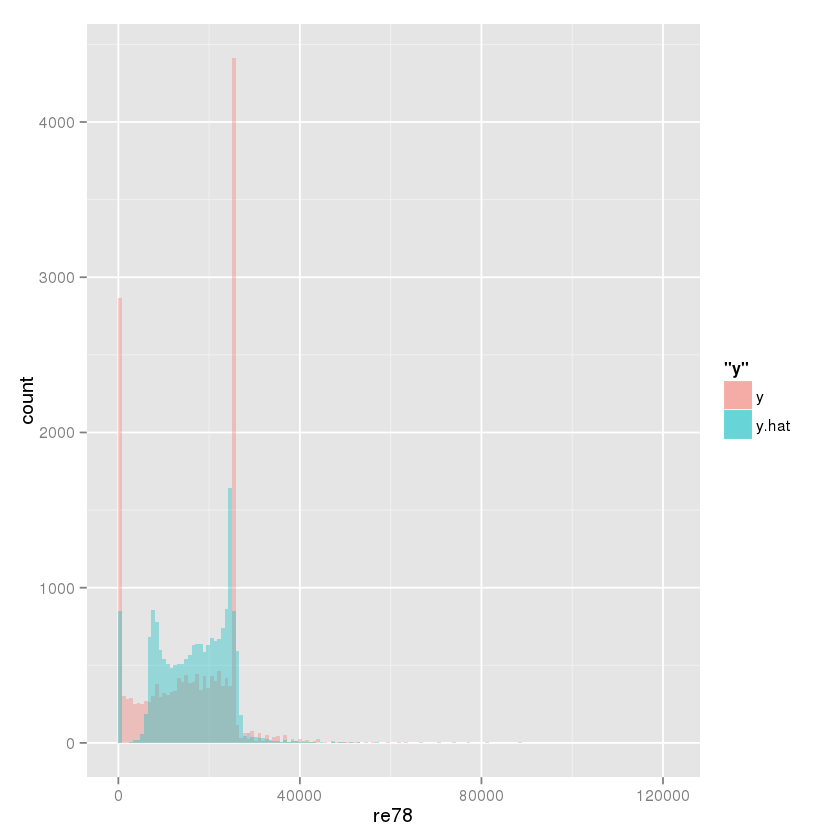

In [12]:
ggplot(data=data.frame(cbind(nsw, y.hat=y.hat))) + 
    geom_histogram(aes(x=re78, fill="y"), alpha=.35, binwidth=(range(nsw$re78)[2] - range(nsw$re78)[1])/150) + 
    geom_histogram(aes(x=y.hat, fill="y.hat"), alpha=.35, binwidth=(range(nsw$re78)[2] - range(nsw$re78)[1])/150)

Differently from exercise 6.5, this model specification better predicts values above \$25,564.67. However, compared to model `fit2.a` in exercise 6.5 we are not very good at predicting values close to zero, although more zero earning predictions are made.